## Transfer Learning using VGG16

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 21.6 MB/s eta 0:00:00


### Loading the Libraries

In [ ]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Flatten, InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
import pickle

from PIL import Image, ImageFont, ImageDraw
from collections import defaultdict

from sklearn.metrics import confusion_matrix
import seaborn as sns
import visualkeras
from tabulate import tabulate
import time
import matplotlib.pyplot as plt
import numpy as np


### Data Acquisition

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download "mengcius/cinic10"


In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:
cinic_dir = '/content'
traindir = cinic_dir + '/train'
validatedir = cinic_dir + '/valid'
testdir = cinic_dir + '/test'

### Data Augmentation and Splitting*

*In CINIC-10 the data is already split for Training, Validation and Testing Sets

In [ ]:
img_height,img_width=32,32
batch_size=128
train_time = []
#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#Training Set without augmentation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  traindir,
  label_mode="categorical",
  seed=524,
  image_size = (img_height,img_width),
  batch_size=batch_size)

#Training Set with augmentation
train_ds_augmented = datagen.flow_from_directory(
    traindir,
    target_size = (img_height,img_width),
    seed = 524,
    batch_size=batch_size,
    class_mode='categorical')

#Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validatedir,
  label_mode="categorical",
  seed=524,
  image_size = (img_height,img_width),
  batch_size=batch_size)

#Test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testdir,
  label_mode="categorical",
  image_size = (img_height,img_width),
  seed=524,
  batch_size=batch_size)

Found 90000 files belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.


### Model Architecture Visualizing

In [ ]:

def architecture(m1, m2, name1, name2):
  font_path = '/content/Arial.ttf'
  font = ImageFont.truetype(font_path, 22)
  color_map = defaultdict(dict)
  color_map[Conv2D]['fill'] = 'orange'
  color_map[Dropout]['fill'] = 'pink'
  color_map[MaxPooling2D]['fill'] = 'red'
  color_map[GlobalAveragePooling2D]['fill'] = 'purple'
  color_map[Dense]['fill'] = 'gray'
  color_map[Flatten]['fill'] = 'teal'
  color_map[BatchNormalization]['fill'] = 'yellow'
  color_map[InputLayer]['fill'] = 'cyan'

  visualkeras.layered_view(m1,color_map=color_map, legend=True, font=font, to_file=f'/content/{name1}.png')
  visualkeras.layered_view(m2, color_map=color_map, legend=True, font=font, to_file=f'/content/{name2}.png')

  image1 = Image.open(f'/content/{name1}.png')
  image2 = Image.open(f'/content/{name2}.png')
  width = max(image1.width, image2.width)


  concatenated_image = Image.fromarray(np.ones((image1.height + image2.height, width, 3), dtype=np.uint8) * 255)
  concatenated_image.paste(image1, (0, 0))
  concatenated_image.paste(image2, (0, image1.height))
  fig, ax = plt.subplots()
  ax.imshow(concatenated_image)
  ax.axis('off')
  plt.show()



## I have made 4 different alternatives on Pre Trained VGG model for analysis

* ### Model 1 :  VGG with untrainable Convolutional Layers   
* ### Model 2 :  VGG and with untrainable Convolutional Layers with Data Augmentation
* ### Model 3 : VGG with untrainable Convolutional layers with Data Augmentation and Regularization with Batch Normalization and Dropout Layers
* ### Model 4 : Fully trainable VGG with Data Augmentation

## Model 1

### Load Pretrained VGG Model

58889256/58889256 [==============================] - 4s 0us/step


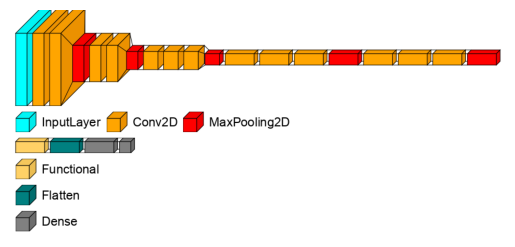

In [ ]:
#m1 Untrainable Conv Layer

vgg_model_1 = Sequential()
pretrained_model_1= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model_1.layers:
        layer.trainable=False

# Removing Avg Max Pooling
new_input = pretrained_model_1.input
output = pretrained_model_1.layers[-2].output
pre_model_1 = Model(inputs=new_input, outputs=output)

# Adding the custom Classifying Dense Layers (without any regularization)
vgg_model_1.add(pre_model_1)
vgg_model_1.add(Flatten())
vgg_model_1.add(Dense(512, activation='relu'))
vgg_model_1.add(Dense(10, activation='softmax'))

# pre_model_1.summary()
# vgg_model_1.summary()
architecture(pre_model_1, vgg_model_1, "m1_p1", "m1_p2")


### Training Model 1

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_1 = vgg_model_1.fit(train_ds, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/55
704/704 [==============================] - 53s 62ms/step - loss: 2.8724 - accuracy: 0.4050 - val_loss: 1.5648 - val_accuracy: 0.4557
Epoch 2/55
704/704 [==============================] - 40s 56ms/step - loss: 1.4076 - accuracy: 0.5054 - val_loss: 1.4806 - val_accuracy: 0.4826
Epoch 3/55
704/704 [==============================] - 41s 57ms/step - loss: 1.2818 - accuracy: 0.5451 - val_loss: 1.4796 - val_accuracy: 0.4903
Epoch 4/55
704/704 [==============================] - 40s 57ms/step - loss: 1.2063 - accuracy: 0.5695 - val_loss: 1.5151 - val_accuracy: 0.4917
Epoch 5/55
704/704 [==============================] - 40s 57ms/step - loss: 1.1470 - accuracy: 0.5905 - val_loss: 1.5756 - val_accuracy: 0.4879
Epoch 6/55
704/704 [==============================] - 39s 55ms/step - loss: 1.0929 - accuracy: 0.6085 - val_loss: 1.6713 - val_accuracy: 0.4841
Epoch 7/55
704/704 [==============================] - 40s 56ms/step - loss: 1.0375 - accuracy: 0.6273 - val_loss: 1.7179 - val_accuracy:

IndexError: ignored

### Saving Model and History (Evaluation Metrics)*

*Can load the model(.h5) or history(.pkl) file for further analysis

In [ ]:
# To save the model and history
# vgg_model_1.save("vgg_model_1.h5")
# with open('history_1.pkl', 'wb') as file:
#     pickle.dump(history_1.history, file)

#To load the model
# vgg_model_1 = load_model("vgg_model_1.h5")
with open('history_1.pkl', 'rb') as file:
  history_1 = pickle.load(file)

## Model 2

### Load Pretrained VGG Model

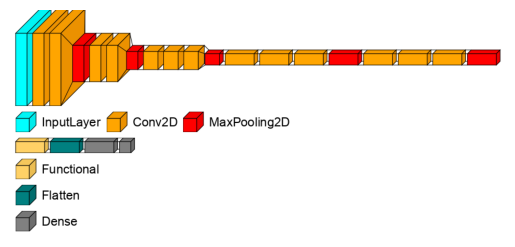

In [ ]:
# m2 VGG and with untrainable Conv Layers with Data Augmentation
#The model is same as m1 but we just use data augmentation during training

vgg_model_2 = Sequential()
pretrained_model_2= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model_2.layers:
        layer.trainable=False

# Removing Avg Max Pooling
new_input = pretrained_model_2.input
output = pretrained_model_2.layers[-2].output
pre_model_2 = Model(inputs=new_input, outputs=output)

# Adding the custom Classifying Dense Layers (without any regularization)
vgg_model_2.add(pre_model_1)
vgg_model_2.add(Flatten())
vgg_model_2.add(Dense(512, activation='relu'))
vgg_model_2.add(Dense(10, activation='softmax'))

# pre_model_2.summary()
# vgg_model_2.summary()
architecture(pre_model_2, vgg_model_2, "m2_p1", "m2_p2")


### Training Model 2

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_2.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_2 = vgg_model_2.fit(train_ds_augmented, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/55
704/704 [==============================] - 111s 155ms/step - loss: 2.9337 - accuracy: 0.3379 - val_loss: 1.6408 - val_accuracy: 0.4301
Epoch 2/55
704/704 [==============================] - 106s 150ms/step - loss: 1.6406 - accuracy: 0.4149 - val_loss: 1.5507 - val_accuracy: 0.4571
Epoch 3/55
704/704 [==============================] - 105s 148ms/step - loss: 1.5858 - accuracy: 0.4344 - val_loss: 1.5339 - val_accuracy: 0.4599
Epoch 4/55
704/704 [==============================] - 107s 152ms/step - loss: 1.5623 - accuracy: 0.4420 - val_loss: 1.4849 - val_accuracy: 0.4760
Epoch 5/55
704/704 [==============================] - 105s 149ms/step - loss: 1.5449 - accuracy: 0.4475 - val_loss: 1.4824 - val_accuracy: 0.4760
Epoch 6/55
704/704 [==============================] - 106s 151ms/step - loss: 1.5409 - accuracy: 0.4505 - val_loss: 1.4751 - val_accuracy: 0.4779
Epoch 7/55
704/704 [==============================] - 103s 146ms/step - loss: 1.5303 - accuracy: 0.4524 - val_loss: 1.4889 -

### Saving Model and History

In [ ]:
# To save the model and history
# vgg_model_2.save("vgg_model_2.h5")
# with open('history_2.pkl', 'wb') as file:
#     pickle.dump(history_2.history, file)

#To load the model
# vgg_model_2 = load_model("vgg_model_2.h5")
with open('history_2.pkl', 'rb') as file:
  history_2 = pickle.load(file)

## Model 3

### Load Pretrained VGG Model

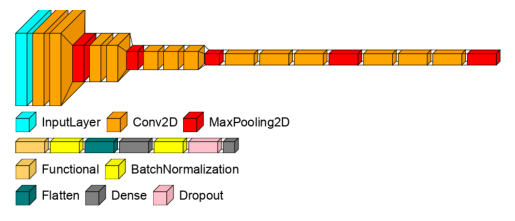

In [ ]:
# m3 VGG with untrainable conv layers with Data Augmentation and
#Regularization with Batch Normalization and Dropout Layers

vgg_model_3 = Sequential()

pretrained_model_3= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model_3.layers:
        layer.trainable=False

# Removing Avg Max Pooling
new_input = pretrained_model_3.input
output = pretrained_model_3.layers[-2].output
pre_model_3 = Model(inputs=new_input, outputs=output)

vgg_model_3.add(pre_model_3)
vgg_model_3.add(BatchNormalization())
vgg_model_3.add(Flatten())
vgg_model_3.add(Dense(512, activation='relu'))
vgg_model_3.add(BatchNormalization())
vgg_model_3.add(Dropout(0.2))
vgg_model_3.add(Dense(10, activation='softmax'))

# pre_model_3.summary()
# vgg_model_3.summary()
architecture(pre_model_3, vgg_model_3, "m3_p1", "m3_p2")

### Training Model 3

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_3.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_3 = vgg_model_3.fit(train_ds_augmented, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))


### Saving Model and History

In [ ]:
# To save the model and history
# vgg_model_3.save("vgg_model_3.h5")
# with open('history_3.pkl', 'wb') as file:
#     pickle.dump(history_3.history, file)

### Loading Model and History

In [ ]:
#To load the model
vgg_model_3 = load_model("vgg_model_3.h5")
with open('history_3.pkl', 'rb') as file:
  history_3_old = pickle.load(file)


### Retraining the model from epoch 55

In [ ]:
#Restart model trainning from epoch = 55 onwards
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_3.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_3_new = vgg_model_3.fit(train_ds_augmented, validation_data=val_ds, epochs=100, callbacks=[es], initial_epoch=55)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 56/100
704/704 [==============================] - 130s 169ms/step - loss: 1.3789 - accuracy: 0.5058 - val_loss: 1.3290 - val_accuracy: 0.5298
Epoch 57/100
704/704 [==============================] - 119s 169ms/step - loss: 1.3745 - accuracy: 0.5073 - val_loss: 1.3293 - val_accuracy: 0.5301
Epoch 58/100
704/704 [==============================] - 115s 163ms/step - loss: 1.3718 - accuracy: 0.5078 - val_loss: 1.3332 - val_accuracy: 0.5288
Epoch 59/100
704/704 [==============================] - 108s 153ms/step - loss: 1.3698 - accuracy: 0.5087 - val_loss: 1.3288 - val_accuracy: 0.5304
Epoch 60/100
704/704 [==============================] - 107s 152ms/step - loss: 1.3720 - accuracy: 0.5083 - val_loss: 1.3310 - val_accuracy: 0.5300
Epoch 61/100
704/704 [==============================] - 108s 153ms/step - loss: 1.3725 - accuracy: 0.5079 - val_loss: 1.3193 - val_accuracy: 0.5340
Epoch 62/100
704/704 [==============================] - 109s 155ms/step - loss: 1.3681 - accuracy: 0.5105 - val_

### Combining the old and new history

In [ ]:
combined_history_3 = {}
for key in history_3_new.history.keys():
    combined_history_3[key] = history_3_old[key] + history_3_new.history[key]

In [ ]:
# To save the model and history
vgg_model_3.save("vgg_model_3.h5")
with open('combined_history_3.pkl', 'wb') as file:
    pickle.dump(combined_history_3, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model 4

### Load Pretrained VGG Model

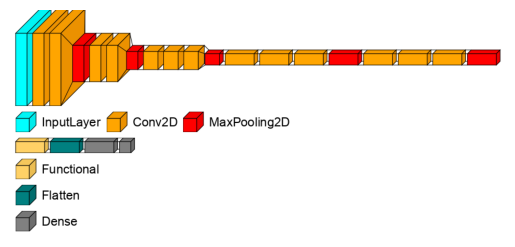

In [ ]:
#m4 Fully trainable VGG with Data Augmentation & no Regularization layers used

vgg_model_4 = Sequential()

pretrained_model_4= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model_4.layers:
        layer.trainable=True

# Removing Avg Max Pooling
new_input = pretrained_model_4.input
output = pretrained_model_4.layers[-2].output
pre_model_4 = Model(inputs=new_input, outputs=output)

vgg_model_4.add(pretrained_model_4)
vgg_model_4.add(Flatten())
vgg_model_4.add(Dense(512, activation='relu'))
vgg_model_4.add(Dense(10, activation='softmax'))


# pre_model_4.summary()
# vgg_model_4.summary()
architecture(pre_model_4, vgg_model_4, "m4_p1", "m4_p2")

### Training Model 4

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_4.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_4 = vgg_model_4.fit(train_ds_augmented, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/55
704/704 [==============================] - 117s 156ms/step - loss: 2.5202 - accuracy: 0.1009 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 2/55
704/704 [==============================] - 109s 155ms/step - loss: 2.0439 - accuracy: 0.1859 - val_loss: 1.8941 - val_accuracy: 0.2293
Epoch 3/55
704/704 [==============================] - 109s 155ms/step - loss: 1.7678 - accuracy: 0.3098 - val_loss: 1.6435 - val_accuracy: 0.3591
Epoch 4/55
704/704 [==============================] - 109s 155ms/step - loss: 1.5510 - accuracy: 0.4029 - val_loss: 1.5117 - val_accuracy: 0.4354
Epoch 5/55
704/704 [==============================] - 109s 154ms/step - loss: 1.4197 - accuracy: 0.4757 - val_loss: 1.4445 - val_accuracy: 0.4839
Epoch 6/55
704/704 [==============================] - 107s 153ms/step - loss: 1.3190 - accuracy: 0.5236 - val_loss: 1.2013 - val_accuracy: 0.5561
Epoch 7/55
704/704 [==============================] - 108s 153ms/step - loss: 1.2590 - accuracy: 0.5481 - val_loss: 1.1835 -

### Saving Model and History

In [ ]:
# # To save the model and history
# vgg_model_4.save("vgg_model_4.h5")
# with open('history_4.pkl', 'wb') as file:
#     pickle.dump(history_4.history, file)

### Loading Model and History

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#To load the model
vgg_model_4 = load_model("/content/drive/MyDrive/vgg_model_4.h5")
with open('history_4.pkl', 'rb') as file:
  history_4_old = pickle.load(file)


### Retraining the model from epoch 55

In [ ]:
#Restart model trainning from epoch = 55 onwards
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_4.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_4_new = vgg_model_4.fit(train_ds_augmented, validation_data=val_ds, epochs=200, callbacks=[es], initial_epoch=55)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 56/200
704/704 [==============================] - 127s 171ms/step - loss: 0.7995 - accuracy: 0.7288 - val_loss: 0.8052 - val_accuracy: 0.7354
Epoch 57/200
704/704 [==============================] - 116s 165ms/step - loss: 0.8099 - accuracy: 0.7213 - val_loss: 0.8586 - val_accuracy: 0.7259
Epoch 58/200
704/704 [==============================] - 116s 165ms/step - loss: 0.9084 - accuracy: 0.6858 - val_loss: 0.8671 - val_accuracy: 0.7096
Epoch 59/200
704/704 [==============================] - 115s 163ms/step - loss: 0.7871 - accuracy: 0.7296 - val_loss: 0.7853 - val_accuracy: 0.7361
Epoch 60/200
704/704 [==============================] - 116s 164ms/step - loss: 0.7759 - accuracy: 0.7347 - val_loss: 0.7780 - val_accuracy: 0.7366
Epoch 61/200
704/704 [==============================] - 114s 162ms/step - loss: 0.7279 - accuracy: 0.7498 - val_loss: 0.8002 - val_accuracy: 0.7274
Epoch 62/200
704/704 [==============================] - 115s 163ms/step - loss: 0.7632 - accuracy: 0.7380 - val_

### Combining the old and new history

In [ ]:
combined_history_4 = {}
for key in history_4_new.history.keys():
    combined_history_4[key] = history_4_old[key] + history_4_new.history[key]



In [ ]:
vgg_model_4.save("vgg_model_4.h5")
with open('combined_history_4.pkl', 'wb') as file:
    pickle.dump(combined_history_4, file)

### Moving models to google drive

In [43]:
# from google.colab import drive
# drive.mount('/content/drive')
# copy it there
# !cp vgg_model_3.h5 /content/drive/MyDrive
# !cp vgg_model_4.h5 /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # The original model, but with image size 224x224 and 1000 classes for
#imagenet, not useful, just for knowledge
#: network architecture with legend using visualkeras

# test_model = tf.keras.applications.VGG16(include_top=True,
#                    input_shape=(224,224,3),
#                    pooling='avg',classes=1000,
#                    weights='imagenet')
# test_model.summary()
# visualkeras.layered_view(test_model, legend=True, font=font)


## Evaluation of Models

### Individual graphs

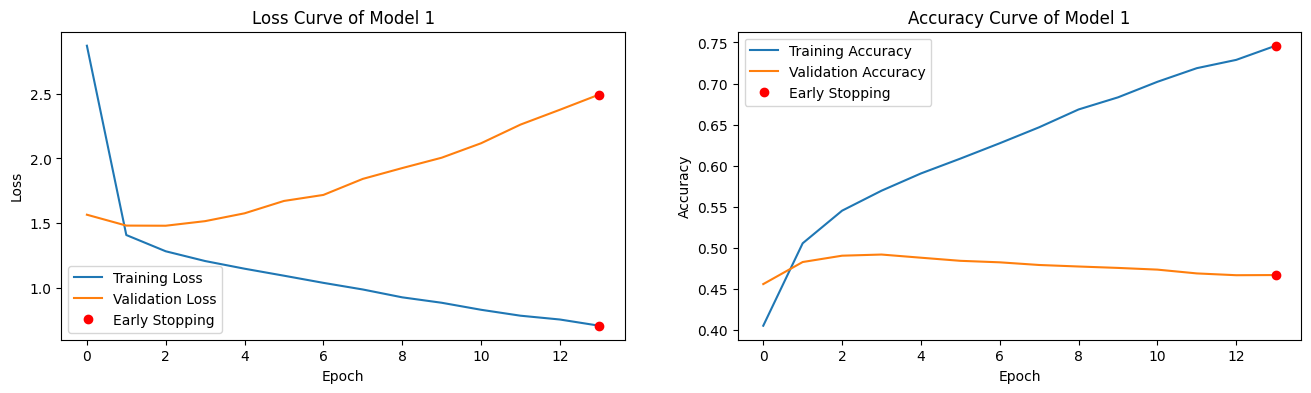

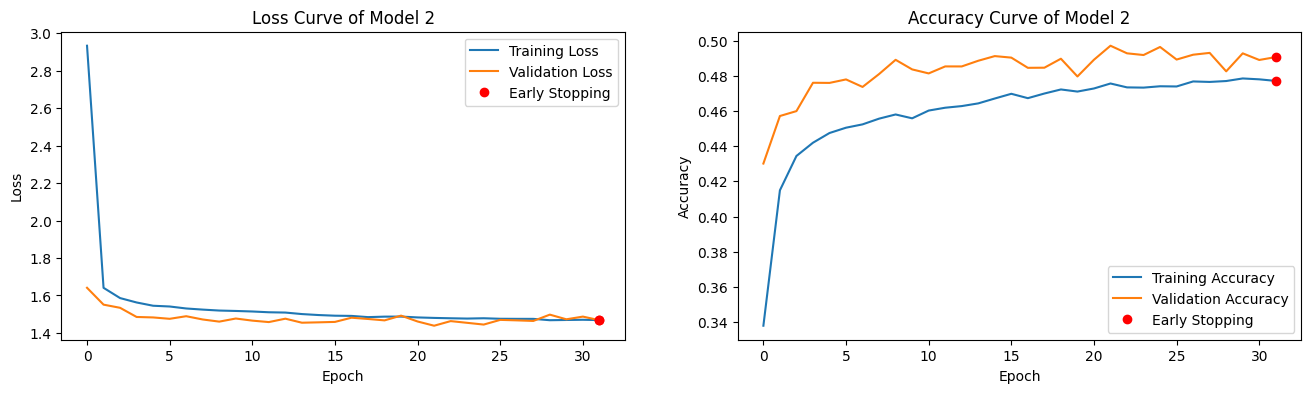

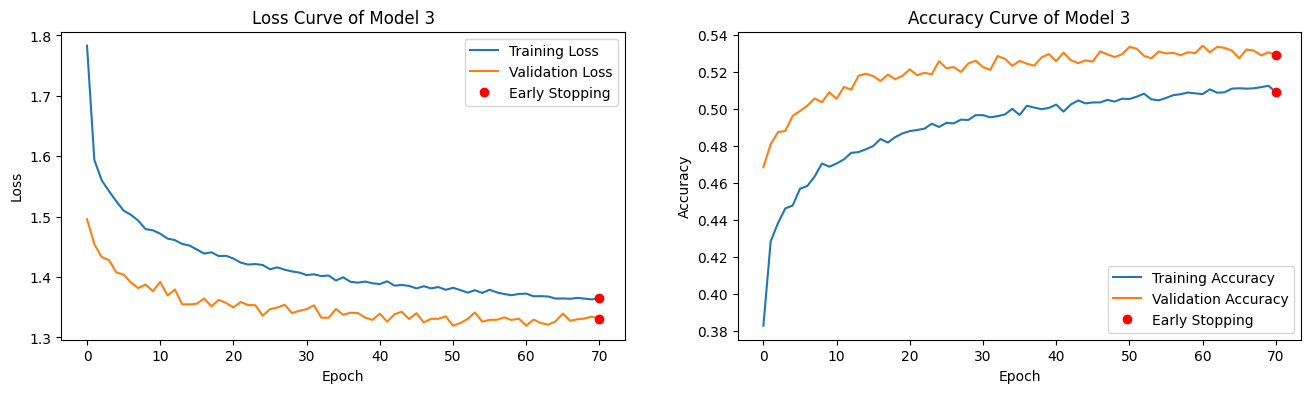

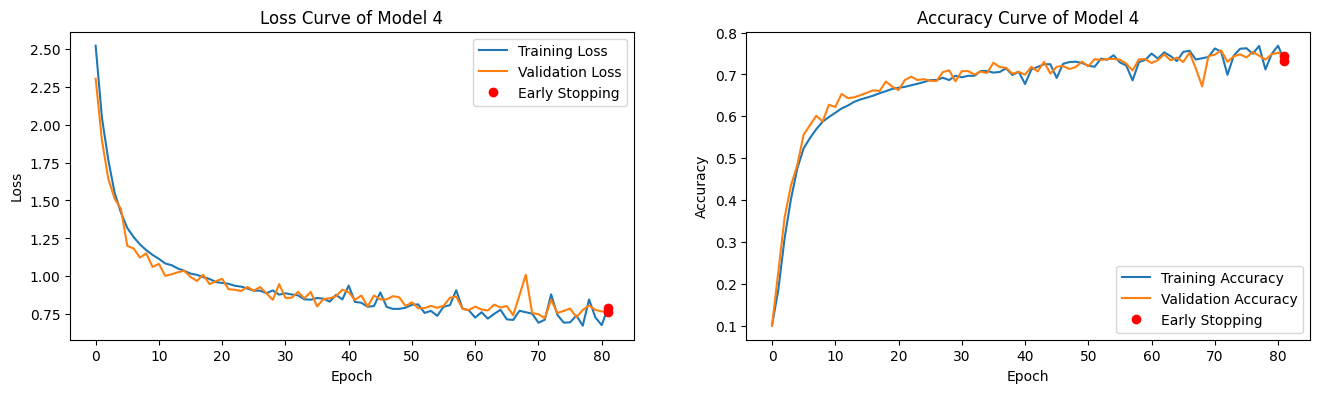

In [ ]:
hist_array = [history_1, history_2, combined_history_3, combined_history_4]

for i, history_i in enumerate(hist_array):
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(history_i['loss'], label='Training Loss')
    ax1.plot(history_i['val_loss'], label='Validation Loss')
    ax1.set_title(f'Loss Curve of Model {i+1}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')


    # Create a new subplot for accuracy
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(history_i['accuracy'], label='Training Accuracy')
    ax2.plot(history_i['val_accuracy'], label='Validation Accuracy')
    ax2.set_title(f'Accuracy Curve of Model {i+1}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    early_stopping_epoch = len(history_i['loss'])
    ax1.plot(early_stopping_epoch - 1, history_i['loss'][-1], 'ro')
    ax1.plot(early_stopping_epoch - 1, history_i['val_loss'][-1], 'ro')
    ax2.plot(early_stopping_epoch - 1, history_i['accuracy'][-1], 'ro')
    ax2.plot(early_stopping_epoch - 1, history_i['val_accuracy'][-1], 'ro')
    ax1.plot([], [], 'ro', label='Early Stopping')
    ax2.plot([], [], 'ro', label='Early Stopping')
    ax1.legend()
    ax2.legend()
    fig.savefig(f'model_{i+1}_training_curves.png')

    plt.show()

### Combined Graphs

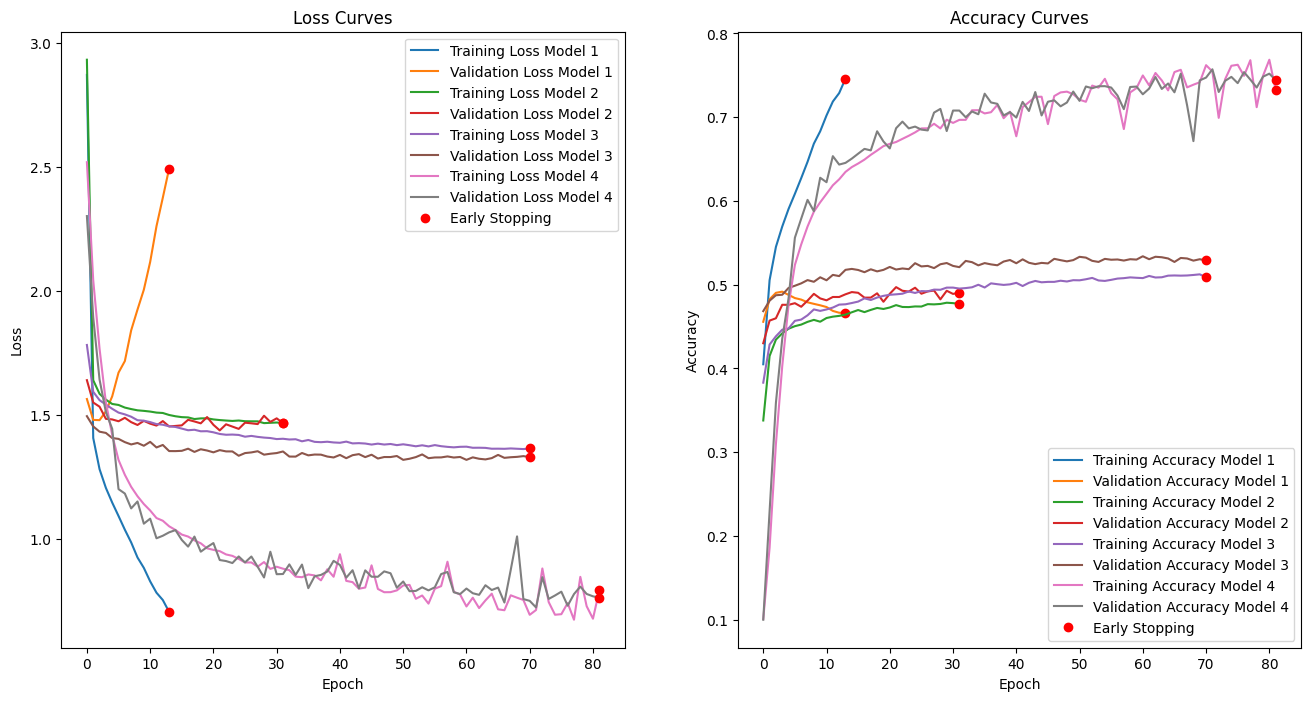

In [ ]:
hist_array = [history_1, history_2, combined_history_3, combined_history_4]

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

for i, history_i in enumerate(hist_array):
    # print(f"{i+1}, Epoch {len(history_i.history['loss'])}")
    # Plot loss and accuracy curves
    ax1.plot(history_i['loss'], label=f'Training Loss Model {i+1}')
    ax1.plot(history_i['val_loss'], label=f'Validation Loss Model {i+1}')
    ax2.plot(history_i['accuracy'], label=f'Training Accuracy Model {i+1}')
    ax2.plot(history_i['val_accuracy'], label=f'Validation Accuracy Model {i+1}')

    early_stopping_epoch = len(history_i['loss'])
    ax1.plot(early_stopping_epoch - 1, history_i['loss'][-1], 'ro')
    ax1.plot(early_stopping_epoch - 1, history_i['val_loss'][-1], 'ro')

    ax2.plot(early_stopping_epoch - 1, history_i['accuracy'][-1], 'ro')
    ax2.plot(early_stopping_epoch - 1, history_i['val_accuracy'][-1], 'ro')

ax1.plot([], [], 'ro', label='Early Stopping')
ax2.plot([], [], 'ro', label='Early Stopping')
ax1.legend()
ax2.legend()
fig.savefig(f'model_{i+1}_combined_training_curves.png')
plt.show()

### Testing the models

In [45]:
vgg_model_1 = load_model("/content/drive/MyDrive/vgg_model_1.h5")
vgg_model_2 = load_model("/content/drive/MyDrive/vgg_model_2.h5")
vgg_model_3 = load_model("/content/drive/MyDrive/vgg_model_3.h5")
vgg_model_4 = load_model("/content/drive/MyDrive/vgg_model_4.h5")
model_list = [vgg_model_1, vgg_model_2, vgg_model_3, vgg_model_4]

results = []
for i, model in enumerate(model_list):
    loss, accuracy = model.evaluate(test_ds)
    results.append([f'Model {i+1}', accuracy, loss])

print(tabulate(results, headers=['Model Name', 'Accuracy', 'Loss'], tablefmt='orgtbl'))


704/704 [==============================] - 33s 45ms/step - loss: 0.7386 - accuracy: 0.7528
| Model Name   |   Accuracy |    Loss |
|--------------+------------+---------|
| Model 1      |   0.486967 | 1.52405 |
| Model 2      |   0.492256 | 1.44828 |
| Model 3      |   0.530911 | 1.3226  |
| Model 4      |   0.752756 | 0.73864 |
